In [15]:
import os
import warnings
import urllib.request
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             matthews_corrcoef, average_precision_score, confusion_matrix)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Global Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

DATA_PATH = 'data/kepler_koi.csv'
URL = 'https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&format=csv'

print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Training Hyperparameters
# Optimized for tabular data stability and convergence
N_SPLITS = 5  # 5-Fold Cross-Validation
EPOCHS = 60
BATCH_SIZE = 256

# Optimizer Parameters
# Reduced learning rate to match smaller batch size
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-2

# Scheduler Parameters (Cosine Annealing)
T_0 = 10
T_MULT = 2

# Augmentation & Regularization
MIXUP_ALPHA = 0.2
LABEL_SMOOTHING = 0.1

In [3]:
# Create directory
os.makedirs(os.path.dirname(DATA_PATH), exist_ok=True)

# Download data if needed
if not os.path.exists(DATA_PATH):
    print("Downloading dataset...")
    try:
        urllib.request.urlretrieve(URL, DATA_PATH)
    except Exception as e:
        print(f"Download failed: {e}")

# Load dataset
df = pd.read_csv(DATA_PATH, comment='#')

# Create binary target: 1 for CONFIRMED/CANDIDATE, 0 for FALSE POSITIVE
df['target'] = df['koi_disposition'].apply(
    lambda x: 1 if x in ['CONFIRMED', 'CANDIDATE'] else 0
)

# Filter numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Remove ID and leakage columns (koi_score)
cols_to_exclude = ['koi_score', 'kepid', 'target']
analysis_df = df_numeric.drop(columns=[c for c in cols_to_exclude if c in df_numeric.columns])

# Compute correlation with target
target_corr = analysis_df.corrwith(df['target']).abs().sort_values(ascending=False)

# Select top 20 features
selected_features = target_corr.head(20).index.tolist()

print("Top 20 Selected Features (by absolute correlation):")
print(target_corr.head(20))

Top 20 Selected Features (by absolute correlation):
koi_fpflag_ss        0.536330
koi_fpflag_co        0.490230
koi_fpflag_ec        0.364957
koi_steff_err1       0.349485
koi_steff_err2       0.318400
koi_teq              0.305006
koi_depth            0.276042
koi_model_snr        0.253358
koi_tce_plnt_num     0.212569
koi_slogg_err2       0.190407
koi_steff            0.187724
koi_slogg_err1       0.145838
koi_duration         0.144505
koi_slogg            0.140392
koi_impact_err1      0.118101
koi_srad_err1        0.116372
koi_srad_err2        0.078610
koi_duration_err2    0.074136
koi_duration_err1    0.074136
koi_period_err2      0.073706
dtype: float64


In [4]:
# Working DataFrame
X_raw = df[selected_features].copy()
y = df['target'].values

# 1. Logarithmic Transformation (log1p) for skewed features
# Candidates for heavy tails (Period, Depth, Temperature, Radius, SNR)
skewed_cols = [
    'koi_period', 'koi_depth', 'koi_time0bk', 'koi_model_snr',
    'koi_teq', 'koi_prad', 'koi_duration', 'koi_insol'
]

print("Applying Log1p transformation to skewed features...")
for col in selected_features:
    if any(s in col for s in skewed_cols) and (X_raw[col].min() >= 0):
        X_raw[col] = np.log1p(X_raw[col])

# 2. Imputation (Median is robust to outliers)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_raw)

# 3. Robust Scaling (Uses IQR, ignores outliers)
scaler = RobustScaler()
X_processed = scaler.fit_transform(X_imputed)

# Hold-out Split (Keep 10% for final testing, use 90% for CV)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_processed, y, test_size=0.1, random_state=42, stratify=y
)

print(f"Training set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test.shape}")

# PyTorch Dataset Wrapper
class KeplerDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

Applying Log1p transformation to skewed features...
Training set shape: (8607, 20)
Test set shape: (957, 20)


In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=4):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.projection = nn.Linear(embed_dim, embed_dim)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        b, seq, _ = x.shape
        qkv = self.qkv(x).reshape(b, seq, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(b, seq, self.embed_dim)
        return self.projection(out)

class SqueezeExcitation(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
      
        # We apply the weights directly to the feature vector.
        excitation = F.relu(self.fc1(x))
        excitation = torch.sigmoid(self.fc2(excitation))
        return x * excitation

class DenseBlock(nn.Module):
    def __init__(self, input_dim, growth_rate, num_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        current_dim = input_dim
        for _ in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.LayerNorm(current_dim),
                nn.Linear(current_dim, growth_rate),
                nn.GELU(),
                nn.Dropout(0.1)
            ))
            current_dim += growth_rate
        self.output_dim = current_dim

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_features = layer(torch.cat(features, dim=-1))
            features.append(new_features)
        return torch.cat(features, dim=-1)

class Hybrid(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        # Input Embedding & Attention
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.GELU()
        )
        self.attn = MultiHeadSelfAttention(128, num_heads=4)
        self.attn_norm = nn.LayerNorm(128)
        
        # Dense Feature Extraction
        self.dense = DenseBlock(128, growth_rate=32, num_layers=3)
        dense_out = self.dense.output_dim
        
        # Transition
        self.transition = nn.Sequential(
            nn.LayerNorm(dense_out),
            nn.Linear(dense_out, 256),
            nn.GELU()
        )
        
        # Residual & SE Block
        self.res_block = nn.Sequential(
            nn.LayerNorm(256),
            nn.Linear(256, 256),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        self.se = SqueezeExcitation(256)
        
        # Final Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        # Attention Stage
        # Add sequence dimension [Batch, 1, Features] for Attention
        x = self.input_proj(x).unsqueeze(1)
        x = self.attn_norm(x + self.attn(x))
        x = x.squeeze(1) # Remove sequence dim for Dense/Linear layers
        
        # Dense Stage
        x = self.dense(x)
        x = self.transition(x)
        
        # Residual Stage
        res = x
        x = self.res_block(x)
        x = self.se(x) # Corrected SE block usage
        x = x + res
        
        return self.classifier(x)

In [6]:
class LabelSmoothingBCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return F.binary_cross_entropy_with_logits(pred, target_smooth)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    index = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [7]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Storage for results
fold_results = {'auc': [], 'accuracy': [], 'f1': [], 'mcc': [], 'ap': []}
fold_histories = [] # Stores loss curves for each fold
best_overall_auc = 0.0

print(f" Starting {N_SPLITS}-Fold Cross-Validation on {len(X_train_full)} samples...")
print(f"   Batch Size: {BATCH_SIZE} | Epochs: {EPOCHS} | LR: {LEARNING_RATE}")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\nTraining Fold {fold + 1}/{N_SPLITS}...")
    
    # 1. Prepare Data
    train_fold = KeplerDataset(X_train_full[train_idx], y_train_full[train_idx])
    val_fold = KeplerDataset(X_train_full[val_idx], y_train_full[val_idx])
    
    # Optimized DataLoaders (num_workers & pin_memory for GPU speed)
    train_loader = DataLoader(
        train_fold, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=2, 
        pin_memory=True
    )
    val_loader = DataLoader(
        val_fold, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True
    )
    
    # 2. Initialize Model, Optimizer & Scheduler
    model = Hybrid(input_dim=len(selected_features)).to(DEVICE)
    
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=LEARNING_RATE, 
        weight_decay=WEIGHT_DECAY
    )
    
    scheduler = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=T_0, 
        T_mult=T_MULT
    )
    
    criterion = LabelSmoothingBCE(smoothing=LABEL_SMOOTHING)
    
    # History for this specific fold
    history = {'train_loss': [], 'val_loss': []}
    
    # 3. Training Loop
    for epoch in range(EPOCHS):
        model.train()
        running_train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            
            # Mixup Data Augmentation
            if np.random.rand() < 0.5:
                X_mix, y_a, y_b, lam = mixup_data(X_batch, y_batch, alpha=MIXUP_ALPHA)
                out = model(X_mix)
                loss = mixup_criterion(criterion, out, y_a, y_b, lam)
            else:
                out = model(X_batch)
                loss = criterion(out, y_batch)
                
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            running_train_loss += loss.item()
        
        # 4. Validation Loop (Run every epoch to track loss evolution)
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                logits = model(X_batch)
                loss = criterion(logits, y_batch) # Calculate Val Loss
                running_val_loss += loss.item()
        
        # Store average losses for this epoch
        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_val_loss = running_val_loss / len(val_loader)
        
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        
        scheduler.step()
    
    # Store complete history for plotting
    fold_histories.append(history)
    
    # 5. Final Metrics for this Fold
    model.eval()
    y_true_fold, y_prob_fold, y_pred_fold = [], [], []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(DEVICE)
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            preds = torch.round(probs)
            
            y_true_fold.extend(y_batch.cpu().numpy())
            y_prob_fold.extend(probs.cpu().numpy())
            y_pred_fold.extend(preds.cpu().numpy())
            
    auc_score = roc_auc_score(y_true_fold, y_prob_fold)
    mcc_score = matthews_corrcoef(y_true_fold, y_pred_fold)
    f1_val = f1_score(y_true_fold, y_pred_fold)
    
    fold_results['auc'].append(auc_score)
    fold_results['mcc'].append(mcc_score)
    fold_results['f1'].append(f1_val)
    
    print(f"   -> Fold {fold+1} Finished | AUC: {auc_score:.4f} | MCC: {mcc_score:.4f}")
    
    # Save best model based on AUC
    if auc_score > best_overall_auc:
        best_overall_auc = auc_score
        torch.save(model.state_dict(), 'best_hybrid_model.pth')

print("\n" + "="*30)
print(f"CROSS-VALIDATION COMPLETE")
print(f"Average AUC: {np.mean(fold_results['auc']):.4f} (+/- {np.std(fold_results['auc']):.4f})")
print(f"Average MCC: {np.mean(fold_results['mcc']):.4f}")
print("="*30)

 Starting 5-Fold Cross-Validation on 8607 samples...
   Batch Size: 256 | Epochs: 60 | LR: 0.0003

Training Fold 1/5...
   -> Fold 1 Finished | AUC: 0.9746 | MCC: 0.8202

Training Fold 2/5...
   -> Fold 2 Finished | AUC: 0.9767 | MCC: 0.8382

Training Fold 3/5...
   -> Fold 3 Finished | AUC: 0.9825 | MCC: 0.8524

Training Fold 4/5...
   -> Fold 4 Finished | AUC: 0.9793 | MCC: 0.8503

Training Fold 5/5...
   -> Fold 5 Finished | AUC: 0.9775 | MCC: 0.8387

CROSS-VALIDATION COMPLETE
Average AUC: 0.9781 (+/- 0.0027)
Average MCC: 0.8399


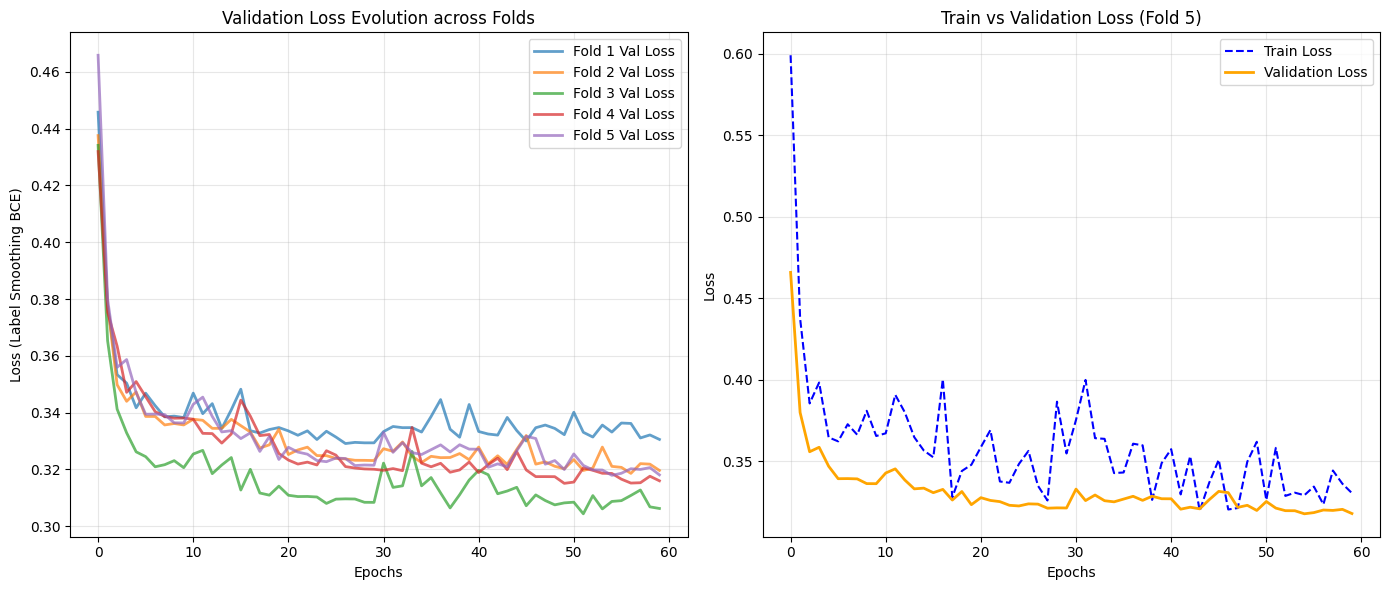

In [10]:
# Plotting Loss Evolution for all folds
plt.figure(figsize=(14, 6))

# Plot 1: All Folds
plt.subplot(1, 2, 1)
for i, history in enumerate(fold_histories):
    # Plot validation loss only for clarity
    plt.plot(history['val_loss'], label=f'Fold {i+1} Val Loss', alpha=0.7, linewidth=2)

plt.title('Validation Loss Evolution across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss (Label Smoothing BCE)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Detailed view of the Last Fold (Train vs Val)
plt.subplot(1, 2, 2)
last_hist = fold_histories[-1]
plt.plot(last_hist['train_loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(last_hist['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title(f'Train vs Validation Loss (Fold {N_SPLITS})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

----------------------------------------
FINAL TEST SET PERFORMANCE
----------------------------------------
Accuracy:          0.9154
ROC AUC:           0.9786
Average Precision: 0.9756
Matthews Corr (MCC): 0.8314
F1 Score:          0.9124
Precision:         0.9336
Recall:            0.8922
----------------------------------------


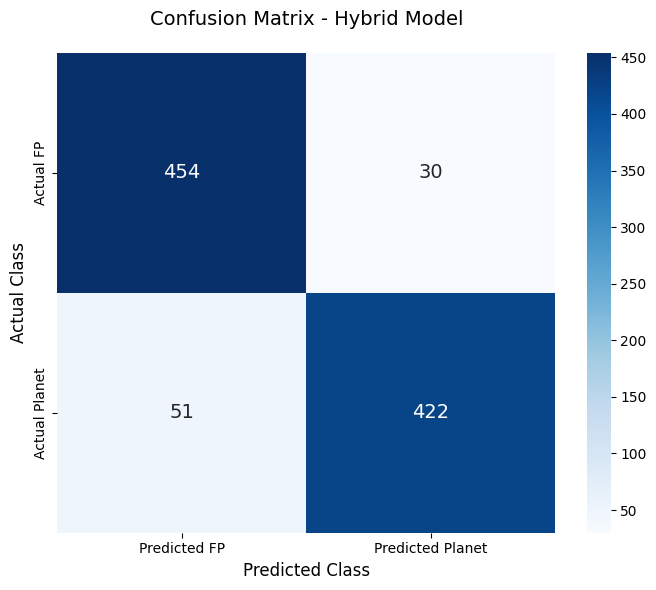

Confusion Matrix (Text):
[[454  30]
 [ 51 422]]

False Positives (Type I Error): 30
False Negatives (Type II Error): 51


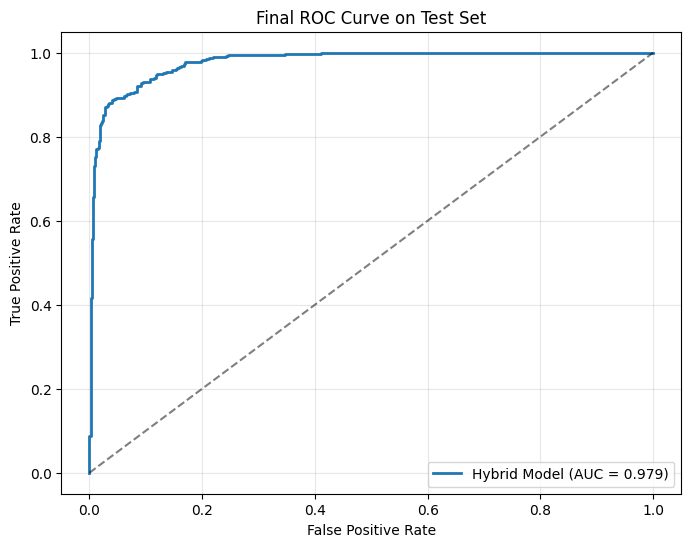

In [16]:
# Load best model
best_model = Hybrid(input_dim=len(selected_features)).to(DEVICE)
best_model.load_state_dict(torch.load('best_hybrid_model.pth', weights_only=True))
best_model.eval()

# Prepare Test Loader
test_dataset = KeplerDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

y_test_true = []
y_test_probs = []
y_test_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        logits = best_model(X_batch)
        probs = torch.sigmoid(logits)
        preds = torch.round(probs)
        
        y_test_true.extend(y_batch.cpu().numpy())
        y_test_probs.extend(probs.cpu().numpy())
        y_test_preds.extend(preds.cpu().numpy())

# Final Metrics Calculation
final_acc = accuracy_score(y_test_true, y_test_preds)
final_auc = roc_auc_score(y_test_true, y_test_probs)
final_prec = precision_score(y_test_true, y_test_preds)
final_rec = recall_score(y_test_true, y_test_preds)
final_f1 = f1_score(y_test_true, y_test_preds)
final_mcc = matthews_corrcoef(y_test_true, y_test_preds)
final_ap = average_precision_score(y_test_true, y_test_probs)

print("-" * 40)
print("FINAL TEST SET PERFORMANCE")
print("-" * 40)
print(f"Accuracy:          {final_acc:.4f}")
print(f"ROC AUC:           {final_auc:.4f}")
print(f"Average Precision: {final_ap:.4f}")
print(f"Matthews Corr (MCC): {final_mcc:.4f}")
print(f"F1 Score:          {final_f1:.4f}")
print(f"Precision:         {final_prec:.4f}")
print(f"Recall:            {final_rec:.4f}")
print("-" * 40)

# Confusion Matrix
# 1. Calcul de la matrice brute
cm = confusion_matrix(y_test_true, y_test_preds)

# 2. Configuration du graphique
plt.figure(figsize=(7, 6))

# Définition des étiquettes pour correspondre à votre rapport
# Rappel : Classe 0 = False Positive, Classe 1 = Planet
xticklabels = ['Predicted FP', 'Predicted Planet']
yticklabels = ['Actual FP', 'Actual Planet']

# 3. Création de la Heatmap
# annot=True : affiche les chiffres dans les cases
# fmt='d' : format entier (pas de notation scientifique)
# cmap='Blues' : palette de couleurs bleue (comme la Figure 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=xticklabels, yticklabels=yticklabels,
            annot_kws={"size": 14}) # Taille de police des chiffres

# 4. Ajout des titres et labels
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.title('Confusion Matrix - Hybrid Model', fontsize=14, pad=20)

# Affichage
plt.tight_layout()
plt.show()

# Affichage textuel pour vérification (console)
print("Confusion Matrix (Text):")
print(cm)
print(f"\nFalse Positives (Type I Error): {cm[0][1]}")
print(f"False Negatives (Type II Error): {cm[1][0]}")

# Plot ROC
fpr, tpr, _ = roc_curve(y_test_true, y_test_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Hybrid Model (AUC = {final_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC Curve on Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()